# Max-3-SAT using QAOA

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set this to true to use the local Aer simulator
USE_LOCAL_SIM = True

# Give any backend name here to choose a specific one
BACKEND_NAME = 'ibm_sherbrooke'

# Max number of retries for errors while running estimator
MAX_RETRIES = 100

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

service = QiskitRuntimeService(channel='ibm_quantum')
real_backend = service.least_busy(operational=True, simulator=False) if not BACKEND_NAME else service.backend(BACKEND_NAME)
sim = AerSimulator.from_backend(real_backend)

if USE_LOCAL_SIM:
    backend = sim
else:
    backend = real_backend
    
print(f"Backend chosen: {backend.name}")

Backend chosen: aer_simulator_from(ibm_sherbrooke)


## Step 1 - Map classical inputs to a quantum problem

### Define the problem

The boolean expression is defined using tuples where each tuple represents a clause. Each member of the tuple represent a literal and the tuple represent the disjunction of literals. Positive numbers in the tuple represent the variables and negative numbers represent the negation of that variable.

In [3]:
from IPython.display import display, Math

# Define the boolean expression
#clauses = [(-1,-3,-2), (1,2,-3), (3,2,1)]
#clauses = [(1, 2, 3),(1, 2, -3), (1, -2, 3), (1, -2, -3), (-1, 2, 3), (-1, 2, -3), (-1, -2, 3)]
clauses = [(1, 2, 3),(1, 2, -3), (1, -2, 3), (1, -2, -3), (-1, 2, 3), (-1, 2, -3), (-1, -2, 3)]

# Get a list of variables
variables = set()
for clause in clauses:
    for variable in clause:
        variables.add(abs(variable))

print("List of variables:")
display(Math(', '.join(f'x{i}' for i in sorted(variables))))

# Print the boolean expression
latex_clauses = []
for clause in clauses:
    clause_literals = [f'\\overline{{x{abs(lit)}}}' if lit < 0 else f'x{abs(lit)}' for lit in clause]
    latex_clause = '(' + ' \\lor '.join(clause_literals) + ')'
    latex_clauses.append(latex_clause)
    
print("Given boolean expression:", end='')
display(Math(' \\land '.join(latex_clauses)))

List of variables:


<IPython.core.display.Math object>

Given boolean expression:

<IPython.core.display.Math object>

### Associate a penalty for each clause

For every type of clause we can associate a penalty to it as shown below. The penalties for each clause can be added together to form a composite penalty function, which can be minimized

| Clause                                                     | Penalty                                                             |
| ---------------------------------------------------------- | ------------------------------------------------------------------- |
| $$x_i \lor x_j \lor x_k$$                                  | $$1 - x_i x_j x_k - x_i - x_j - x_k + x_i x_j + x_j x_k + x_i x_k$$ |
| $$x_i \lor x_j \lor \overline{x_k}$$                       | $$x_k - x_i x_k - x_j x_k + x_i x_j x_k$$                           |
| $$x_i \lor \overline{x_j} \lor \overline{x_k}$$            | $$x_j x_k - x_i x_j x_k$$                                           |
| $$\overline{x_i} \lor \overline{x_j} \lor \overline{x_k}$$ | $$x_i x_j x_k$$                                                     |


In [4]:
from sympy import symbols, simplify

# Define the symbols required for the clause penalties
penalty_symbols = symbols('x_i, x_j, x_k')
xi, xj, xk = penalty_symbols

# Define penalties for each type of clause based on the number of negatives
penalties = [None] * 4
penalties[0] = 1 - (xi * xj * xk) - xi - xj - xk + (xi * xj) + (xj * xk) + (xi * xk)
penalties[1] = xk - (xi * xk) - (xj * xk) + (xi * xj * xk)
penalties[2] = (xj * xk) - (xi * xj * xk)
penalties[3] = (xi * xj * xk)

# Define the symbols for every variable in the expression
syms = symbols(' '.join(f'x_{i}' for i in sorted(variables)))
symbol_map = {}
for variable in variables:
    for symbol in syms:
        if int(str(symbol)[2:]) == variable:
            symbol_map[variable] = symbol

# Initialize an empty expression
penalty = simplify(0)

for clause in clauses:
    # Get the positive and negative literals
    positive_literals = [abs(x) for x in clause if x > 0]
    negative_literals = [abs(x) for x in clause if x < 0]
    
    # Check the number of negatives and choose the appropriate penalty for clause
    n = len(negative_literals)
    clause_penalty = penalties[n]
    
    # Substitute the actual variables in the penalty equation
    for index, variable in enumerate(positive_literals):
        clause_penalty = clause_penalty.subs(penalty_symbols[index], symbol_map[variable])
    for index, variable in enumerate(negative_literals):
        clause_penalty = clause_penalty.subs(penalty_symbols[2 - index], symbol_map[variable])

    # Add the clause penalty to the composite penalty
    penalty += clause_penalty

print("Composite penalty function:")
penalty

Composite penalty function:


-x_1*x_2*x_3 + 1

### Calculate cost hamiltonian

In [5]:
syms = symbols(' '.join(f'Z_{i}' for i in sorted(variables)))
pauli_op_map = {}
for variable in variables:
    for symbol in syms:
        if int(str(symbol)[2:]) == variable:
            pauli_op_map[variable] = symbol

hamiltonian_op = penalty
for variable in variables:
    hamiltonian_op = hamiltonian_op.subs(symbol_map[variable], (1 - pauli_op_map[variable])/2)

hamiltonian_op = hamiltonian_op.expand()
hamiltonian_op

Z_1*Z_2*Z_3/8 - Z_1*Z_2/8 - Z_1*Z_3/8 + Z_1/8 - Z_2*Z_3/8 + Z_2/8 + Z_3/8 + 7/8

In [6]:
from operator import mul
from functools import reduce
from itertools import combinations
from qiskit.quantum_info import SparsePauliOp

hamiltonian_coefficients = hamiltonian_op.as_coefficients_dict()
pauli_list = [('III', hamiltonian_coefficients[1])]

for i in range(1, 4):
    terms = [reduce(mul, x, 1) for x in combinations(pauli_op_map.values(), i)]
    for term in terms:
        if term in hamiltonian_coefficients:
            pauli_string = ''.join('Z' if x in term.free_symbols else 'I' for x in pauli_op_map.values())[::-1]
            pauli_list.append((pauli_string, hamiltonian_coefficients[term]))


hamiltonian = SparsePauliOp.from_list(pauli_list)
print(hamiltonian)

SparsePauliOp(['III', 'IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[ 0.875+0.j,  0.125+0.j,  0.125+0.j,  0.125+0.j, -0.125+0.j, -0.125+0.j,
 -0.125+0.j,  0.125+0.j])


### Build Ansatz for the QAOA algorithm

Ansatz in basic gates: 


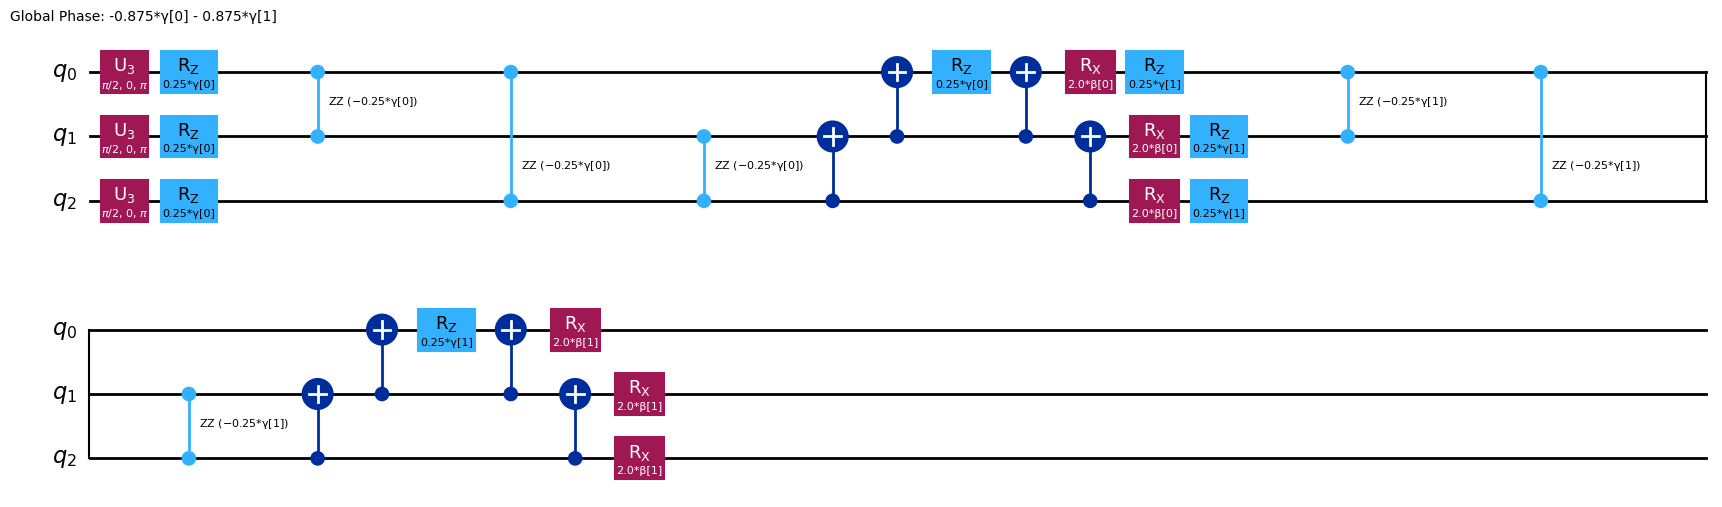

In [7]:
# QAOA ansatz circuit
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(hamiltonian, reps=2)

print("Ansatz in basic gates: ")
ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

QAOA structure with reps=1:


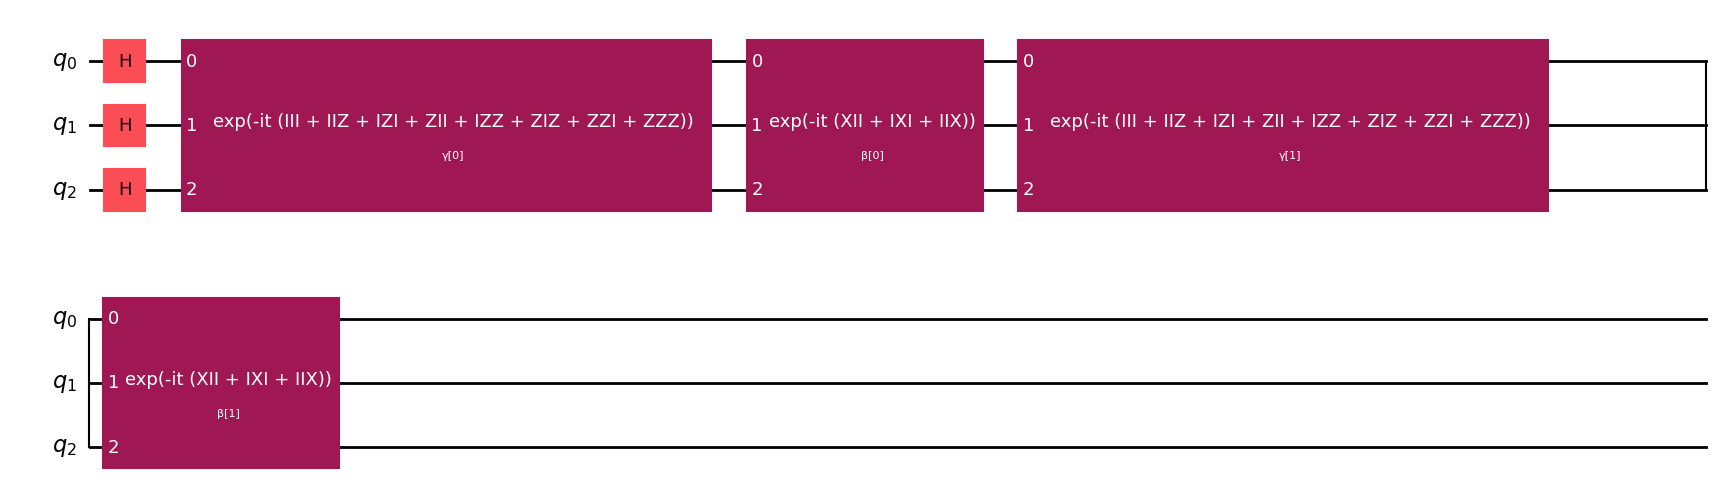

In [8]:
print("QAOA structure with reps=1:")
ansatz.decompose().draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution.

### ISA Circuit

Schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize the circuit for the selected backend and make it compatible with the instruction set architecture (ISA) of the backend.


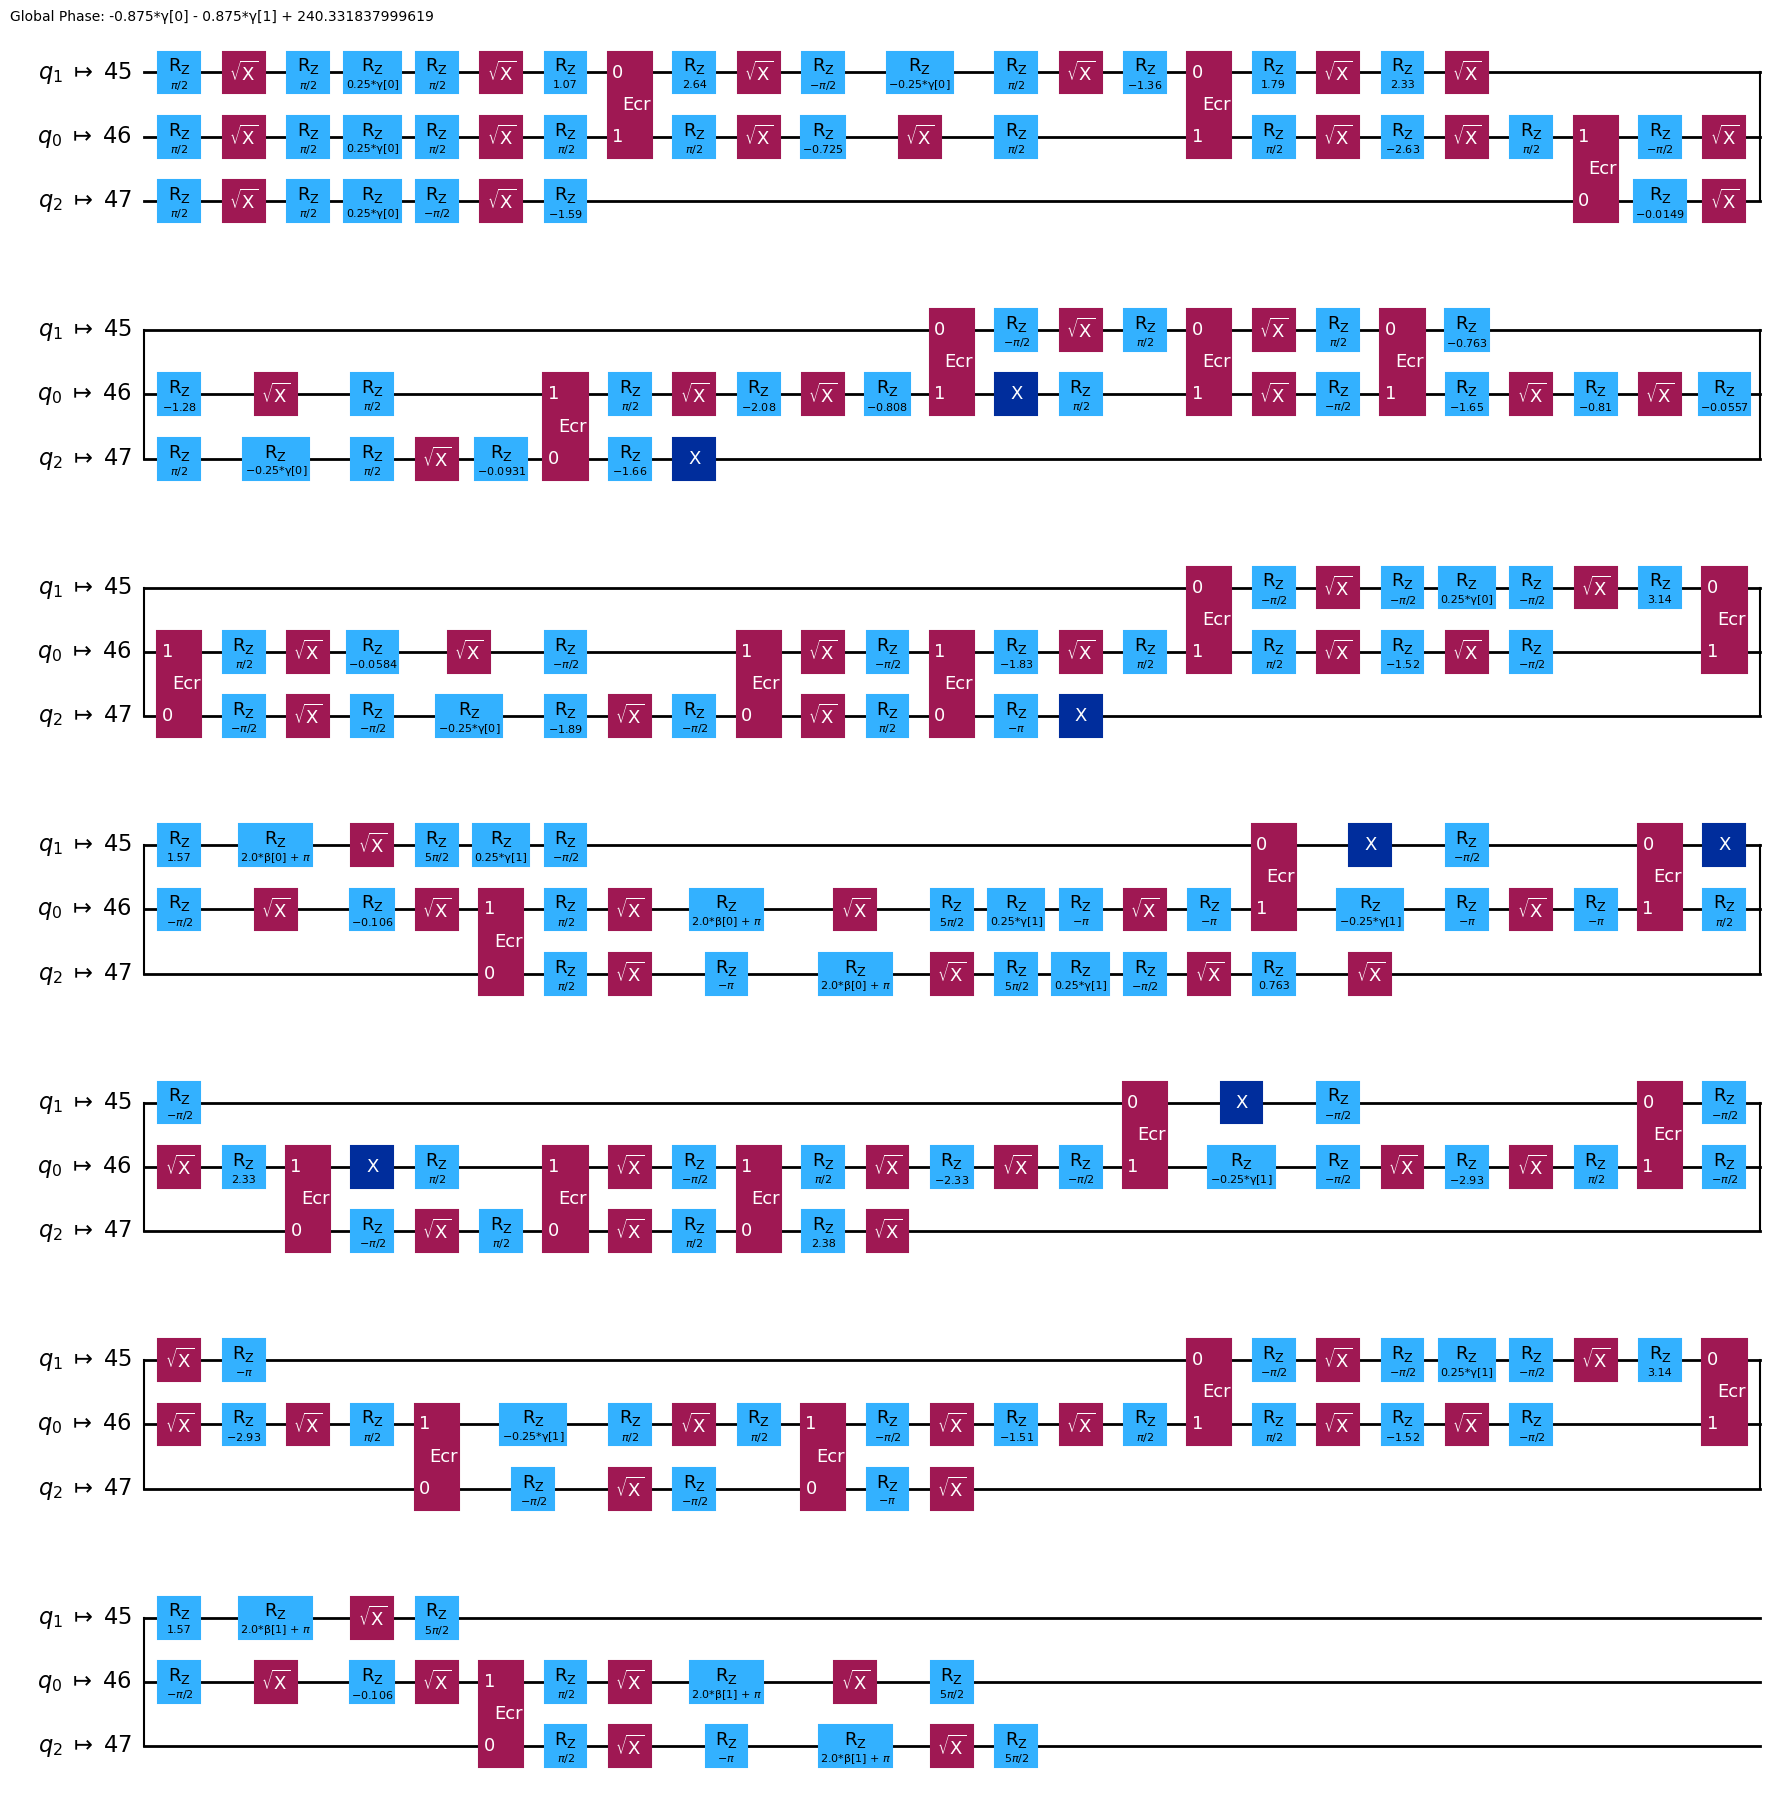

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables

Transform the Hamiltonian to make it backend compatible before running jobs.

In [10]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 3: Execute using Qiskit Primitives

Use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all calls within a single block.

In [11]:
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

session = None
estimator = None

def initialize_estimator():
    global session
    global estimator
    
    session = Session(backend=backend)
    estimator = Estimator(session=session)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.default_shots = 10_000

initialize_estimator()

Define the cost function over which to minimize. This is done by computing the expectation value of the Hamiltonian with respect to the parameterized ansatz circuit.

In [12]:
# Cost function returing estimate of energy from estimator
num_retries = 0

def cost_func(params, ansatz, hamiltonian, estimator):
    global num_retries
    try:
        pub = (ansatz, [hamiltonian], [params])
        result = estimator.run(pubs=[pub]).result()
        cost = result[0].data.evs[0]
    except Exception as e:
        print("Error while running estimator: ", str(e))
        if num_retries < MAX_RETRIES:
            initialize_estimator()
            num_retries += 1
            return cost_func(params, ansatz, hamiltonian, estimator)
        raise e

    return cost

Use the [COBYLA routine from SciPy through the minimize function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):


In [13]:
import numpy as np
from scipy.optimize import minimize

# Set an initial set of random parameters:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
# Uncomment the below line and comment the above line to compare with the Powell estimator
#res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="Powell")

The solution will be encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, a [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) primitive is instantiated with the same `Session`.


In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(session=session)
sampler.options.dynamical_decoupling.enable = True
sampler.options.default_shots = 10_000

In [15]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.500732421875
       x: [ 2.771e+00  3.835e+00  3.778e+00  1.654e+00]
     nit: 5
   direc: [[ 2.365e-04 -1.699e-02 -2.609e-01 -3.439e-01]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]
           [ 6.307e-02  1.516e-02 -2.278e-01 -2.190e-02]]
    nfev: 329


## Step 4: Post-process, return result in classical format

Plug in the solution vector of parameter angles (`x`) into the ansatz circuit to get the result

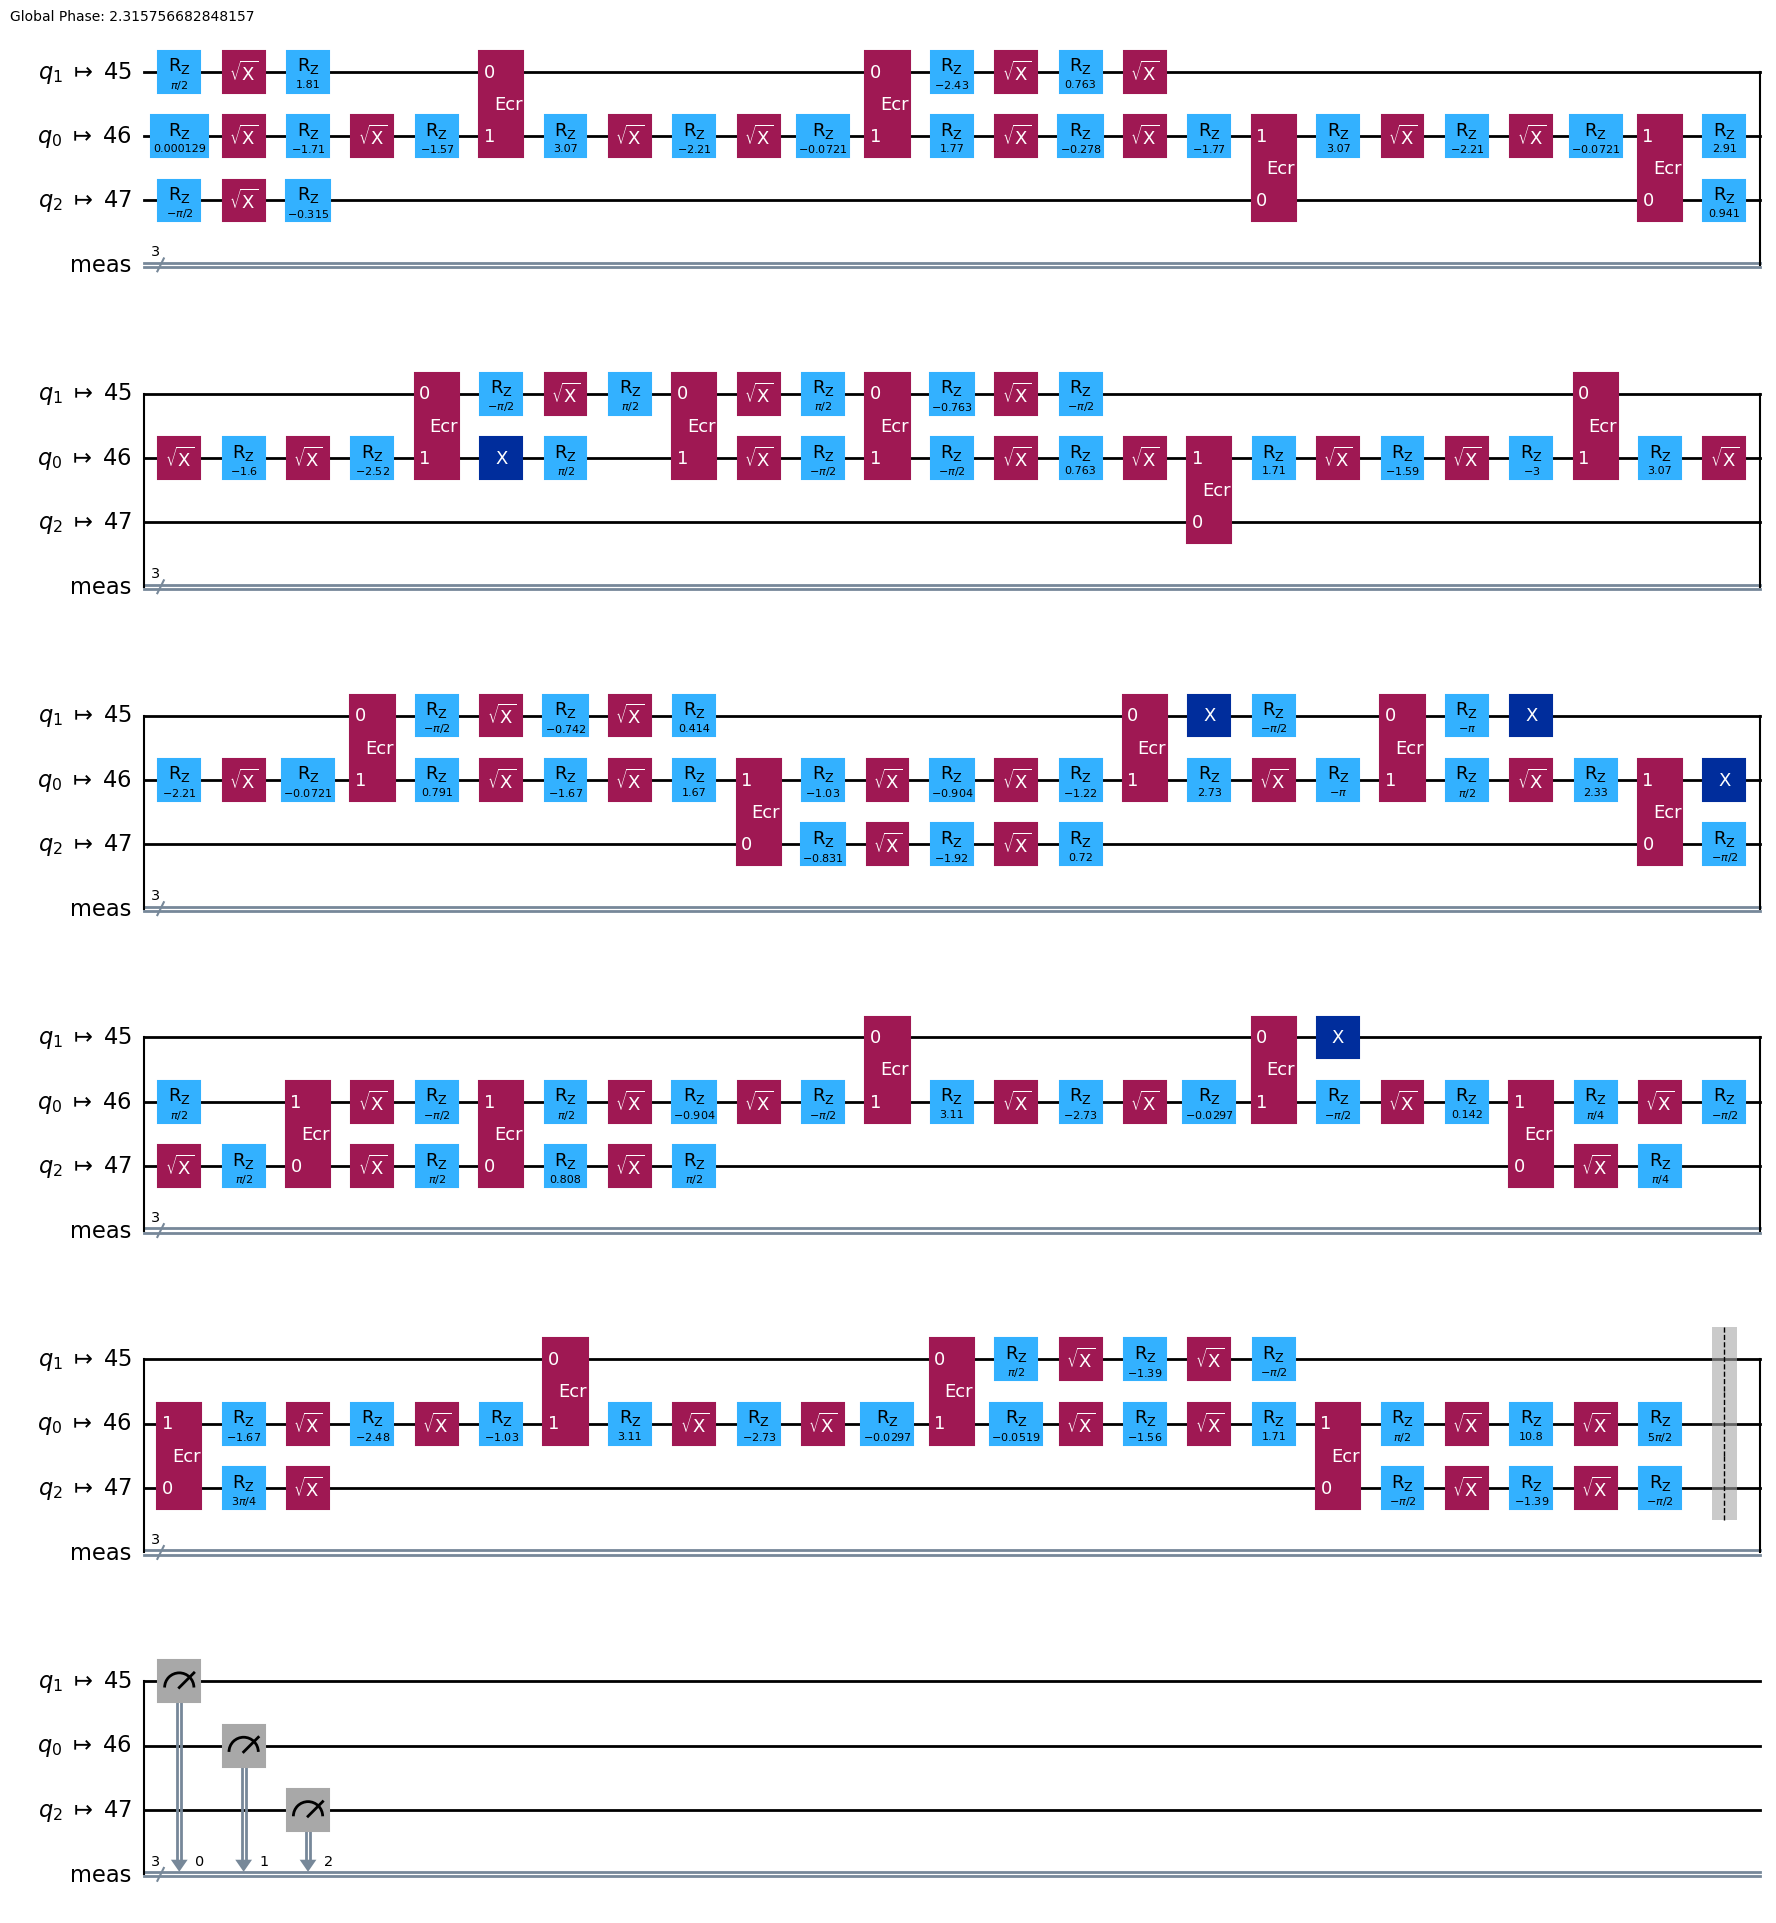

In [16]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)

# Add measurements to the circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [17]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
session.close()

Visualize the solution

In [18]:
from IPython.display import HTML
from qiskit.visualization import plot_distribution

# Calculate the satisfied clauses for each case
data = []
for case, probability in samp_dist.items():
    values = dict(zip(sorted(variables), map(int, reversed(list(case)))))
    row = list(reversed(list(case)))
    sat = penalty
    for variable in variables:
        sat = sat.subs(symbol_map[variable], values[variable])
    sat = len(clauses) - sat
    row.extend([sat, probability/10000])
    data.append(row)

# Sort the data according to probability
data.sort(key=lambda x: x[len(variables) + 1], reverse=True)

# Add header for the table
data.insert(0, [f'x{i}' for i in sorted(variables)] + ["Satisfied Clauses", "Probability" ])

<IPython.core.display.Math object>

x1,x2,x3,Satisfied Clauses,Probability
1,1,1,7,0.4907
0,0,0,6,0.1783
1,0,0,6,0.0599
1,1,0,6,0.0566
0,1,0,6,0.0546
0,1,1,6,0.0545
1,0,1,6,0.0528
0,0,1,6,0.0526


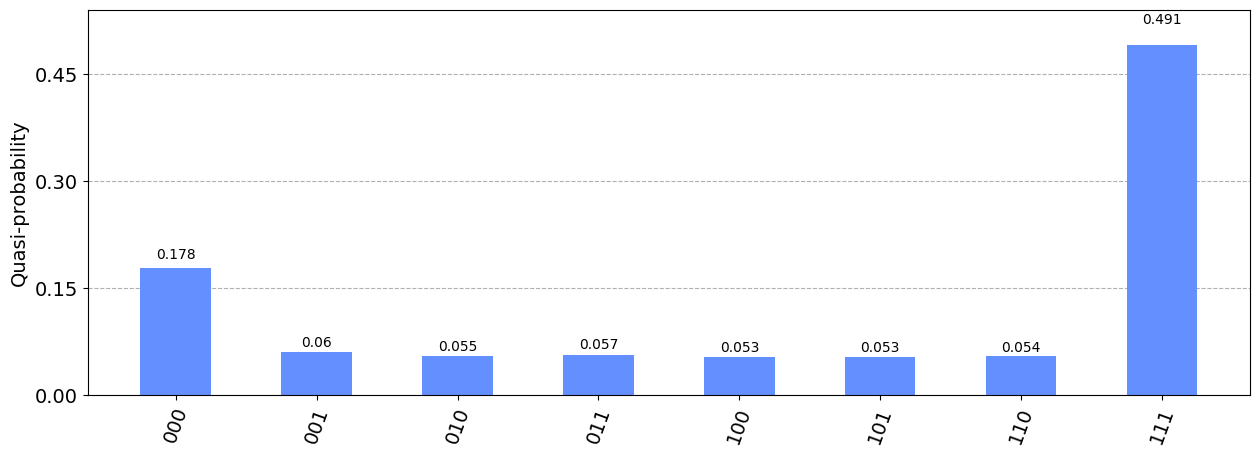

In [19]:
# Display the equation and solutions
display(Math(' \\land '.join(latex_clauses)))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
))

# Show histogram
plot_distribution(samp_dist, figsize=(15, 5))

In [20]:
def score(data):
    average_satisfied_clauses = sum(item[3] for item in data)/len(data)
    score = sum((item[3]-average_satisfied_clauses)*item[4] for item in data)
    return score

In [21]:
score(data[1:])

0.365700000000000